# REINFORCE in PyTorch

Just like we did before for Q-learning, this time we'll design a PyTorch network to learn `CartPole-v0` via policy gradient (REINFORCE).

Most of the code in this notebook is taken from approximate Q-learning, so you'll find it more or less familiar and even simpler.

In [1]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash
    !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

In [2]:
import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

A caveat: with some versions of `pyglet`, the following cell may crash with `NameError: name 'base' is not defined`. The corresponding bug report is [here](https://github.com/pyglet/pyglet/issues/134). If you see this error, try restarting the kernel.

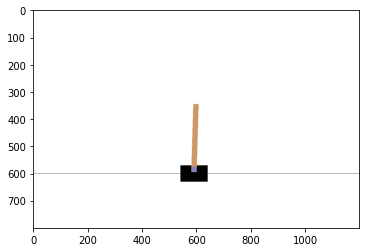

In [3]:
env = gym.make("CartPole-v0")

# gym compatibility: unwrap TimeLimit
if hasattr(env, '_max_episode_steps'):
    env = env.env

env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape

plt.imshow(env.render("rgb_array"))

# Building the network for REINFORCE

For REINFORCE algorithm, we'll need a model that predicts action probabilities given states.

For numerical stability, please __do not include the softmax layer into your network architecture__.
We'll use softmax or log-softmax where appropriate.

In [4]:
import torch
import torch.nn as nn

In [8]:
# Build a simple neural network that predicts policy logits. 
# Keep it simple: CartPole isn't worth deep architectures.
model = nn.Sequential(
    nn.Linear(state_dim[0], 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, n_actions)
)

#### Predict function

Note: output value of this function is not a torch tensor, it's a numpy array.
So, here gradient calculation is not needed.
<br>
Use [no_grad](https://pytorch.org/docs/stable/autograd.html#torch.autograd.no_grad)
to suppress gradient calculation.
<br>
Also, `.detach()` (or legacy `.data` property) can be used instead, but there is a difference:
<br>
With `.detach()` computational graph is built but then disconnected from a particular tensor,
so `.detach()` should be used if that graph is needed for backprop via some other (not detached) tensor;
<br>
In contrast, no graph is built by any operation in `no_grad()` context, thus it's preferable here.

In [25]:
def predict_probs(states):
    """ 
    Predict action probabilities given states.
    :param states: numpy array of shape [batch, state_shape]
    :returns: numpy array of shape [batch, n_actions]
    """
    # convert states, compute logits, use softmax to get probability

    logits = model(torch.FloatTensor(states))
    softmax = torch.softmax(logits, dim=-1).detach().numpy()

    return softmax

In [26]:
test_states = np.array([env.reset() for _ in range(5)])
test_probas = predict_probs(test_states)
assert isinstance(test_probas, np.ndarray), \
    "you must return np array and not %s" % type(test_probas)
assert tuple(test_probas.shape) == (test_states.shape[0], env.action_space.n), \
    "wrong output shape: %s" % np.shape(test_probas)
assert np.allclose(np.sum(test_probas, axis=1), 1), "probabilities do not sum to 1"

### Play the game

We can now use our newly built agent to play the game.

In [107]:
def generate_session(env, t_max=10000):
    """ 
    Play a full session with REINFORCE agent.
    Returns sequences of states, actions, and rewards.
    """
    # arrays to record session
    states, actions, rewards = [], [], []
    s = env.reset()

    for t in range(t_max):
        # action probabilities array aka pi(a|s)
        action_probs = predict_probs(np.array([s]))[0]

        # Sample action with given probabilities.
        a = np.random.choice(n_actions, p=action_probs)
        new_s, r, done, info = env.step(a)

        # record session history to train later
        states.append(s)
        actions.append(a)
        rewards.append(r)

        s = new_s
        if done:
            break

    return states, actions, rewards

In [44]:
# test it
states, actions, rewards = generate_session(env)

### Computing cumulative rewards

$$
\begin{align*}
G_t &= r_t + \gamma r_{t + 1} + \gamma^2 r_{t + 2} + \ldots \\
&= \sum_{i = t}^T \gamma^{i - t} r_i \\
&= r_t + \gamma * G_{t + 1}
\end{align*}
$$

In [71]:
def get_cumulative_rewards(rewards,  # rewards at each step
                           gamma=0.99  # discount for reward
                           ):
    """
    Take a list of immediate rewards r(s,a) for the whole session 
    and compute cumulative returns (a.k.a. G(s,a) in Sutton '16).
    
    G_t = r_t + gamma*r_{t+1} + gamma^2*r_{t+2} + ...

    A simple way to compute cumulative rewards is to iterate from the last
    to the first timestep and compute G_t = r_t + gamma*G_{t+1} recurrently

    You must return an array/list of cumulative rewards with as many elements as in the initial rewards.
    """
    cum_rewards = np.zeros(len(rewards))
    cum_rewards[-1] = rewards[-1]

    for i in range(len(cum_rewards) - 2, -1, -1):
        cum_rewards[i] = rewards[i] + cum_rewards[i + 1] * gamma

    return cum_rewards

In [72]:
get_cumulative_rewards(rewards)
assert len(get_cumulative_rewards(list(range(100)))) == 100
assert np.allclose(
    get_cumulative_rewards([0, 0, 1, 0, 0, 1, 0], gamma=0.9),
    [1.40049, 1.5561, 1.729, 0.81, 0.9, 1.0, 0.0])
assert np.allclose(
    get_cumulative_rewards([0, 0, 1, -2, 3, -4, 0], gamma=0.5),
    [0.0625, 0.125, 0.25, -1.5, 1.0, -4.0, 0.0])
assert np.allclose(
    get_cumulative_rewards([0, 0, 1, 2, 3, 4, 0], gamma=0),
    [0, 0, 1, 2, 3, 4, 0])
print("looks good!")

looks good!


#### Loss function and updates

We now need to define objective and update over policy gradient.

Our objective function is

$$ J \approx  { 1 \over N } \sum_{s_i,a_i} G(s_i,a_i) $$

REINFORCE defines a way to compute the gradient of the expected reward with respect to policy parameters. The formula is as follows:

$$ \nabla_\theta \hat J(\theta) \approx { 1 \over N } \sum_{s_i, a_i} \nabla_\theta \log \pi_\theta (a_i \mid s_i) \cdot G_t(s_i, a_i) $$

We can abuse PyTorch's capabilities for automatic differentiation by defining our objective function as follows:

$$ \hat J(\theta) \approx { 1 \over N } \sum_{s_i, a_i} \log \pi_\theta (a_i \mid s_i) \cdot G_t(s_i, a_i) $$

When you compute the gradient of that function with respect to network weights $\theta$, it will become exactly the policy gradient.

In [73]:
def to_one_hot(y_tensor, ndims):
    """ helper: take an integer vector and convert it to 1-hot matrix. """
    y_tensor = y_tensor.type(torch.LongTensor).view(-1, 1)
    y_one_hot = torch.zeros(
        y_tensor.size()[0], ndims).scatter_(1, y_tensor, 1)
    return y_one_hot

In [79]:
# Your code: define optimizers
optimizer = torch.optim.Adam(model.parameters(), 1e-3)


def train_on_session(states, actions, rewards, gamma=0.99, entropy_coef=1e-3):
    """
    Takes a sequence of states, actions and rewards produced by generate_session.
    Updates agent's weights by following the policy gradient above.
    Please use Adam optimizer with default parameters.
    """

    # cast everything into torch tensors
    states = torch.tensor(states, dtype=torch.float32)
    actions = torch.tensor(actions, dtype=torch.int32)
    cumulative_returns = np.array(get_cumulative_rewards(rewards, gamma))
    cumulative_returns = torch.tensor(cumulative_returns, dtype=torch.float32)

    # predict logits, probas and log-probas using an agent.
    logits = model(states)
    probs = nn.functional.softmax(logits, -1)
    log_probs = nn.functional.log_softmax(logits, -1)

    assert all(isinstance(v, torch.Tensor) for v in [logits, probs, log_probs]), \
        "please use compute using torch tensors and don't use predict_probs function"

    # select log-probabilities for chosen actions, log pi(a_i|s_i)
    log_probs_for_actions = torch.sum(
        log_probs * to_one_hot(actions, env.action_space.n), dim=1)
   
    # Compute loss here. Don't forgen entropy regularization with `entropy_coef` 
    entropy = - torch.mean(torch.sum(probs * log_probs), dim=-1)
    loss = - torch.mean(log_probs_for_actions * cumulative_returns) - entropy * entropy_coef

    # Gradient descent step
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    # technical: return session rewards to print them later
    return np.sum(rewards)

### The actual training

In [ ]:
for i in range(100):
    rewards = [train_on_session(*generate_session(env)) for _ in range(100)]  # generate new sessions
    
    print("mean reward:%.3f" % (np.mean(rewards)))
    
    if np.mean(rewards) > 5000:
        print("You Win!")  # but you can train even further
        break

mean reward:108.250
mean reward:123.890
mean reward:157.860
mean reward:220.740
mean reward:264.370
mean reward:214.970
mean reward:183.160
mean reward:178.470
mean reward:210.600
mean reward:439.970
mean reward:524.840
mean reward:192.840
mean reward:9.630
mean reward:39.350
mean reward:66.210
mean reward:9.820
mean reward:87.940
mean reward:228.740
mean reward:150.250
mean reward:15.930
mean reward:9.690
mean reward:9.320
mean reward:9.490
mean reward:9.830
mean reward:135.130
mean reward:419.170
mean reward:1930.550
mean reward:1336.750
mean reward:1426.390
mean reward:2168.280
mean reward:1065.460
mean reward:1698.050
mean reward:684.860
mean reward:455.130
mean reward:681.070


### Results & video

In [105]:
def generate_session_for_present(env, t_max=10000):
    """
    Play a full session with REINFORCE agent.
    Returns sequences of states, actions, and rewards.
    """
    # arrays to record session
    states, actions, rewards = [], [], []
    s = env.reset()
    env.render()

    for t in range(t_max):
        # action probabilities array aka pi(a|s)
        action_probs = predict_probs(np.array([s]))[0]

        # Sample action with given probabilities.
        a = np.random.choice(n_actions, p=action_probs)
        new_s, r, done, info = env.step(a)

        # record session history to train later
        states.append(s)
        actions.append(a)
        rewards.append(r)

        s = new_s
        if done:
            print(t)
            break
    print(np.sum(rewards))
    return states, actions, rewards


In [106]:
for i in range(100):
    generate_session_for_present(env)
None

206
207.0
227
228.0
208
209.0
213
214.0
219
220.0
212
213.0
211
212.0
228
229.0
217
218.0
242
243.0
225
226.0
205
206.0
211
212.0
232
233.0
235
236.0
207
208.0
220
221.0
222
223.0
234
235.0
202
203.0
200
201.0
227
228.0
209
210.0
212
213.0
230
231.0
253
254.0
219
220.0
223
224.0
215
216.0
218
219.0
235
236.0
197
198.0
243
244.0
220
221.0
211
212.0
233
234.0
223
224.0
234
235.0
220
221.0
220
221.0
237
238.0
217
218.0
212
213.0
216
217.0
217
218.0
225
226.0
229
230.0
214
215.0
215
216.0
221
222.0
220
221.0
229
230.0
215
216.0
237
238.0
214
215.0
207
208.0
236
237.0
229
230.0
212
213.0
207
208.0
213
214.0
206
207.0
213
214.0
232
233.0
236
237.0
224
225.0
211
212.0
242
243.0
216
217.0
227
228.0
238
239.0
219
220.0
248
249.0
217
218.0
201
202.0
231
232.0
202
203.0
226
227.0
226
227.0
228
229.0
224
225.0
214
215.0
216
217.0
204
205.0
209
210.0
216
217.0
219
220.0
235
236.0
236
237.0
249
250.0
224
225.0
233
234.0
217
218.0
224
225.0
224
225.0
213
214.0
224
225.0
219
220.0
223
224.0
207
208.0


In [99]:
# Record sessions

import gym.wrappers

with gym.wrappers.Monitor(gym.make("CartPole-v0"), directory="videos", force=True) as env_monitor:
    sessions = [generate_session_for_present(env_monitor) for _ in range(1)]

session ended


In [100]:
# Show video. This may not work in some setups. If it doesn't
# work for you, you can download the videos and view them locally.

from pathlib import Path
from IPython.display import HTML

video_names = sorted([s for s in Path('videos').iterdir() if s.suffix == '.mp4'])

HTML("""
<video width="1280" height="720" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(video_names[-1]))  # You can also try other indices